In [9]:
import numpy as np
from matplotlib import pyplot as plt
import pymc3 as pm
import arviz as az

In [10]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 10
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [22]:
number_data_point = 500

# A probabilistic generator for the innovation term.
innovation_mean = 1 # this is the c term in the wikipedia construction
innovation_std = 1 # this is the standard deviation of the innovation 
innovation = np.random.normal(loc=0.0, scale=innovation_std, size = number_data_point)

# A probabilistic generator for tao
tao_mean = 5 
tao_std = 0
tao = np.random.normal(loc=tao_mean, scale=tao_std, size = number_data_point)


intensity_mean = innovation_mean / (1 - np.exp(-1/tao_mean)) # this is the expectation value of all intensity signals
intensity_variance = innovation_std**2 / (1 - np.exp(-2/tao_mean)) # this is the expectation value of all intensity signals
X = intensity_mean*np.ones(number_data_point) #initialize data matrix

print('The mean intensity is {}'.format(intensity_mean))
print('The variance of intensity is {}'.format(intensity_variance))
print('variance normalized by mean-squared is {}. This will be the magnitude of the first pt of the Autocorrelation function'.format(intensity_variance/intensity_mean**2))

The mean intensity is 5.516655566126993
The variance of intensity is 3.0332447817197368
variance normalized by mean-squared is 0.09966799462495587. This will be the magnitude of the first pt of the Autocorrelation function


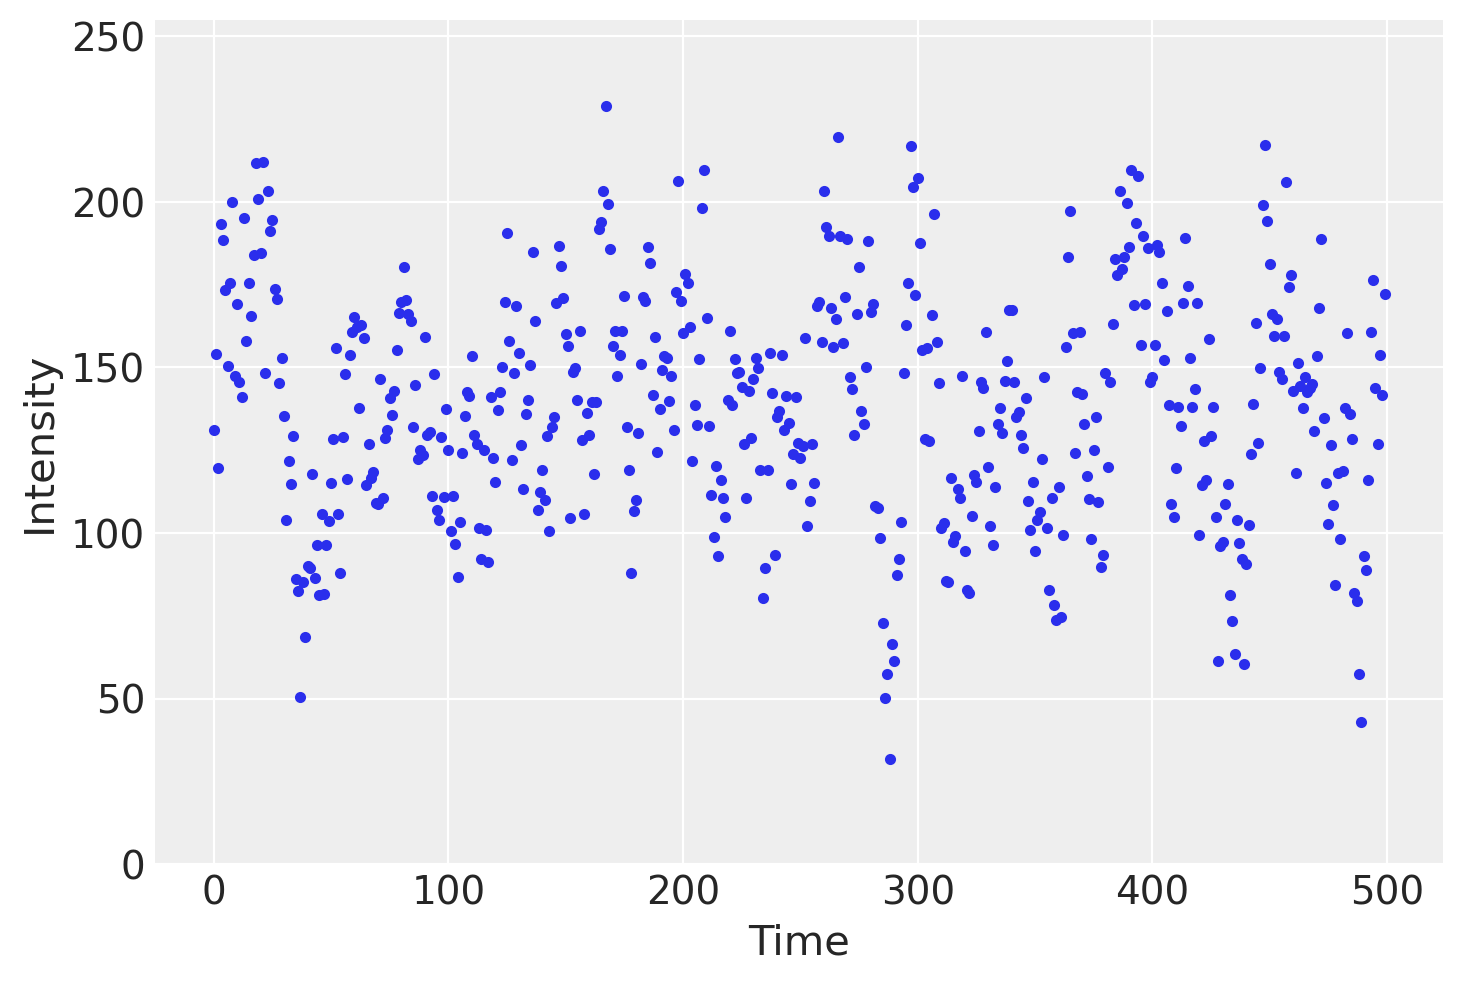

In [23]:
#Generate model data
phi = np.exp(-1/tao)
for i in np.arange(number_data_point-1):
    X[i+1]= innovation_mean + phi[i]*X[i] + innovation[i] # Data not normalized
    
X_normalized = X/intensity_mean

#Add camera noise

camera_noise_mean = 5
camera_noise_std = 1
camera_noise = np.random.normal(loc = camera_noise_mean, scale = camera_noise_std, size = number_data_point)

quantization = 255 # 8 bit image
image_brightness = 0.5 # the brightness of image divided by full quantization

X_simulated_data = X_normalized*quantization*image_brightness+camera_noise

#Plot model data
#plt.plot(np.arange(number_data_point),X_normalized,'o')
plt.plot(np.arange(number_data_point),X_simulated_data,'.')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.ylim([0,quantization])
plt.show()

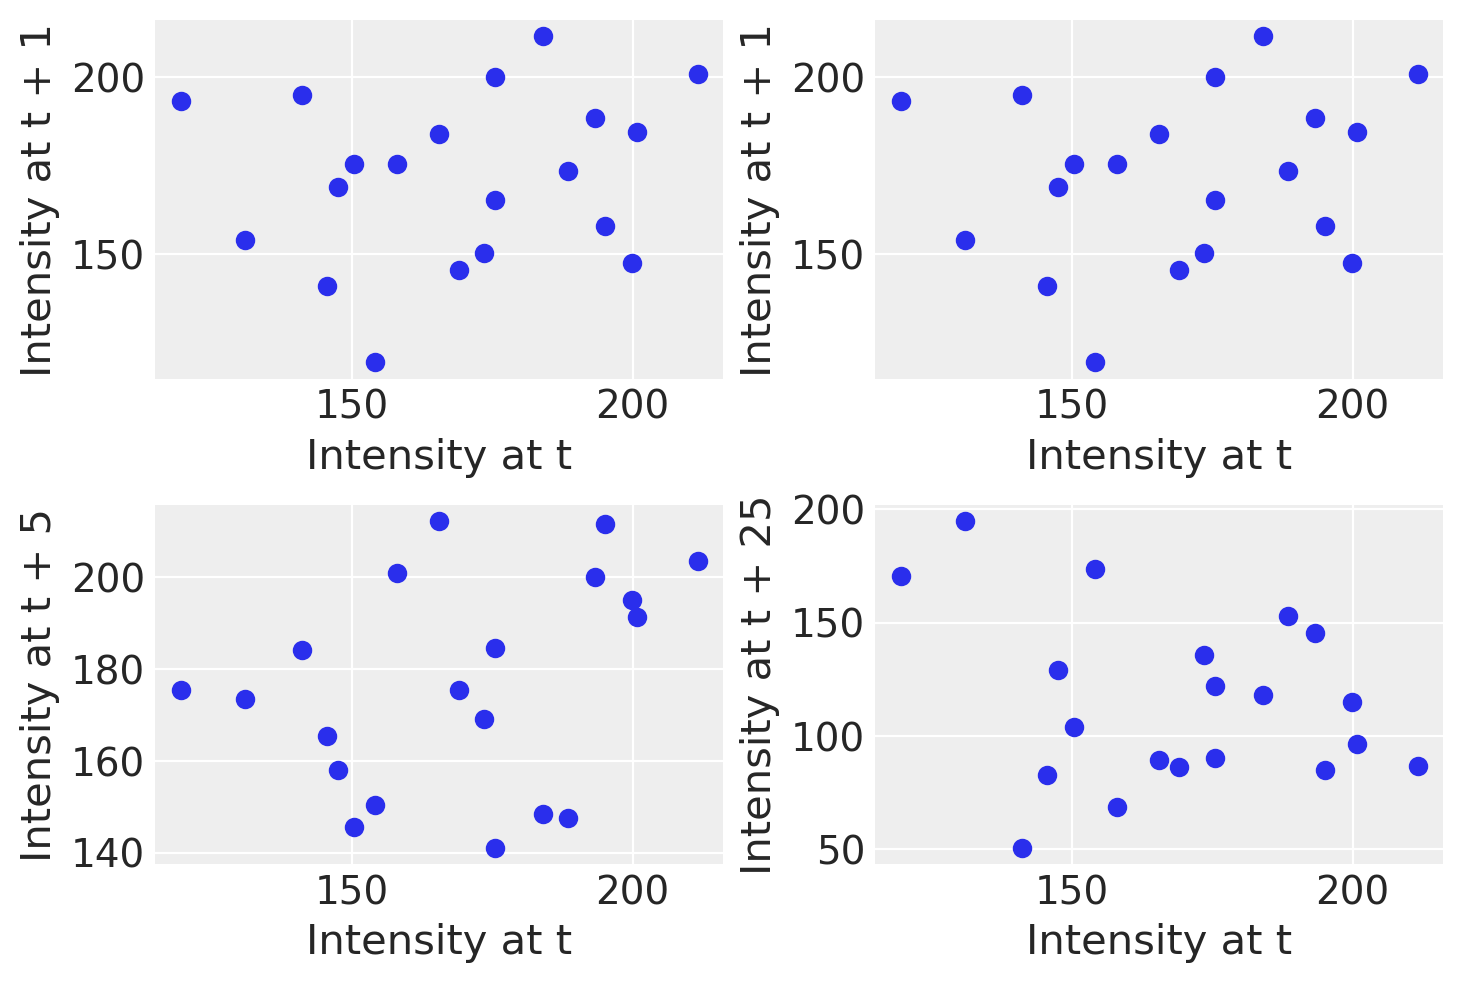

In [27]:
#Correlation between neighboring pts
averaged_pts = 20 
pth_neighbor = np.array([1,round(0.2*tao_mean),round(tao_mean),round(5*tao_mean)])
number_correlation_illustration = len(pth_neighbor)
for i in np.arange(number_correlation_illustration):
    plt.subplot(2,2,i+1)
    #plt.plot(X_normalized[0:averaged_pts],X_normalized[pth_neighbor[i]:pth_neighbor[i]+averaged_pts],'o')
    plt.plot(X_simulated_data[0:averaged_pts],X_simulated_data[pth_neighbor[i]:pth_neighbor[i]+averaged_pts],'o')
    plt.xlabel('Intensity at t')
    #plt.ylabel('$X_{t+1}$'.format(pth_neighbor))
    plt.ylabel('Intensity at t + {}'.format(pth_neighbor[i]))
plt.show()

Autocorrelation:

$\frac{<I(t)I(t+\tau)>}{<I(t)><I(t+\tau)>} - 1$

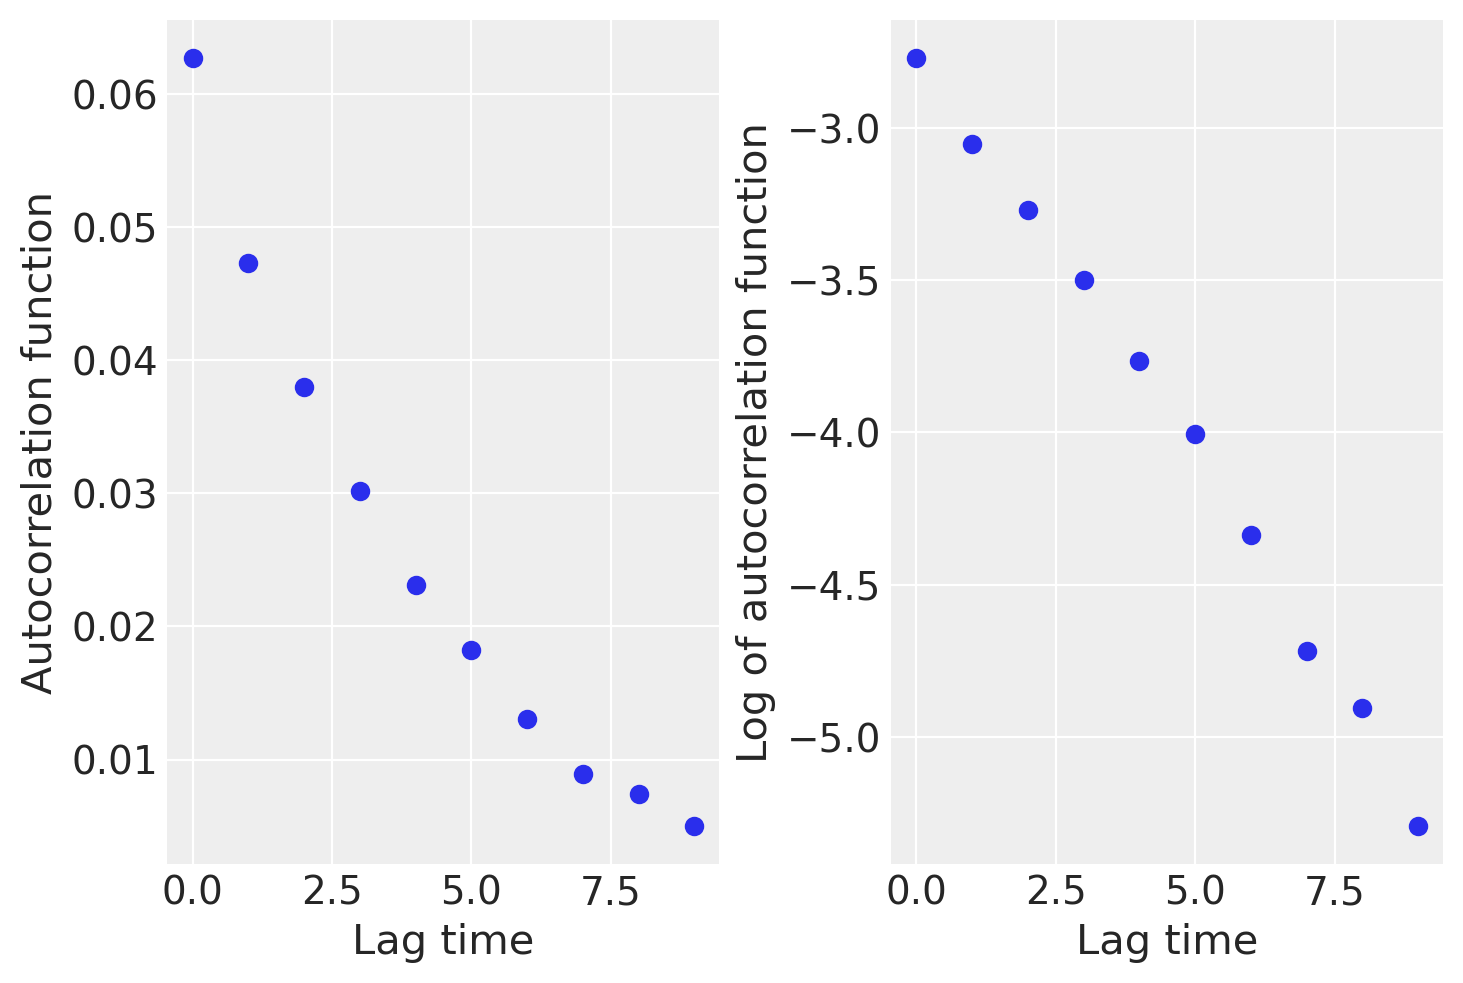

In [29]:
# Autocorrelation function
longest_lag_time = 2*tao_mean
lag_time = np.arange(longest_lag_time)
averaged_pts = number_data_point - longest_lag_time #Need averaged_pts+lognes_lag_time < number_data_point
Intensity_matrix = np.zeros([longest_lag_time,averaged_pts])
Correlation_matrix = np.zeros([longest_lag_time,averaged_pts])

for i in lag_time:
    #Intensity_matrix[i] = X_normalized[i:i+averaged_pts] 
    Intensity_matrix[i] = X_simulated_data[i:i+averaged_pts] 
    Correlation_matrix[i] = Intensity_matrix[0]*Intensity_matrix[i]

Autocorrelation = np.average(Correlation_matrix, axis = 1) / (np.average(Intensity_matrix[0])*np.average(Intensity_matrix, axis = 1)) - 1

plt.subplot(121)
plt.plot(lag_time,Autocorrelation,'o')   
plt.xlabel('Lag time')
plt.ylabel('Autocorrelation function')
plt.subplot(122)
plt.plot(lag_time,np.log(Autocorrelation),'o')   
plt.xlabel('Lag time')
plt.ylabel('Log of autocorrelation function')
plt.show()

# Bayesian parameter estimation with pymc3
ar1_model = pm.Model()

with ar1_model:
    
    # 'phi'is ln(-1/tau) used in our generative model
    decay_time = pm.Uniform("decay_time",lower = 0, upper = 50) 
    stationarity = np.exp(-1/decay_time)

    # 'precision' is 1/(variance of innovation). As we use normalized data, this term has to be divided by intensity_mean squared
    precision = pm.Uniform("precision", lower = 0 , upper = 10/(np.var(X_simulated_data)*(1-np.exp(-2/10)))) 
    # process mean
    center = pm.Uniform("center", lower = 0, upper = quantization) # this is the mean of normalized data

    likelihood = pm.AR1("y", k=stationarity, tau_e=precision, observed = X_simulated_data - center)

In [53]:
# Bayesian parameter estimation with pymc3
ar1_model = pm.Model()

with ar1_model:
    
    # 'phi'is ln(-1/tau) used in our generative model
    decay_time = pm.Uniform("decay_time",lower = 0, upper = 50) 
    stationarity = np.exp(-1/decay_time)

    # 'precision' is 1/(variance of innovation). As we use normalized data, this term has to be divided by intensity_mean squared
    precision = pm.Uniform("precision", lower = 0 , upper = 10/(innovation_std**2/(intensity_mean/(quantization*image_brightness))**2)) 
    # process mean
    center = pm.Uniform("center", lower = 0, upper = quantization) # this is the mean of normalized data
    
    # camera noise
    camera_noise = pm.Uniform("camera_noise",lower = 0, upper = 0.05*quantization,shape = number_data_point)
    
    likelihood = pm.AR1("y", k=stationarity, tau_e=precision, observed = X_normalized - center - camera_noise)


In [54]:
estimate = pm.find_MAP(model = ar1_model)

In [55]:
with ar1_model:
    trace = pm.sample(1000, tune=2000, init="advi+adapt_diag", random_seed=RANDOM_SEED)
    idata = az.from_pymc3(trace)

/var/folders/4c/vpfj2cz13377t1cw_xxjyj4w0000gn/T/ipykernel_26965/137214802.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000, tune=2000, init="advi+adapt_diag", random_seed=RANDOM_SEED)
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 21900
Interrupted at 21,899 [10%]: Average Loss = 1,633.8
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [camera_noise, center, precision, decay_time]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 23 seconds.


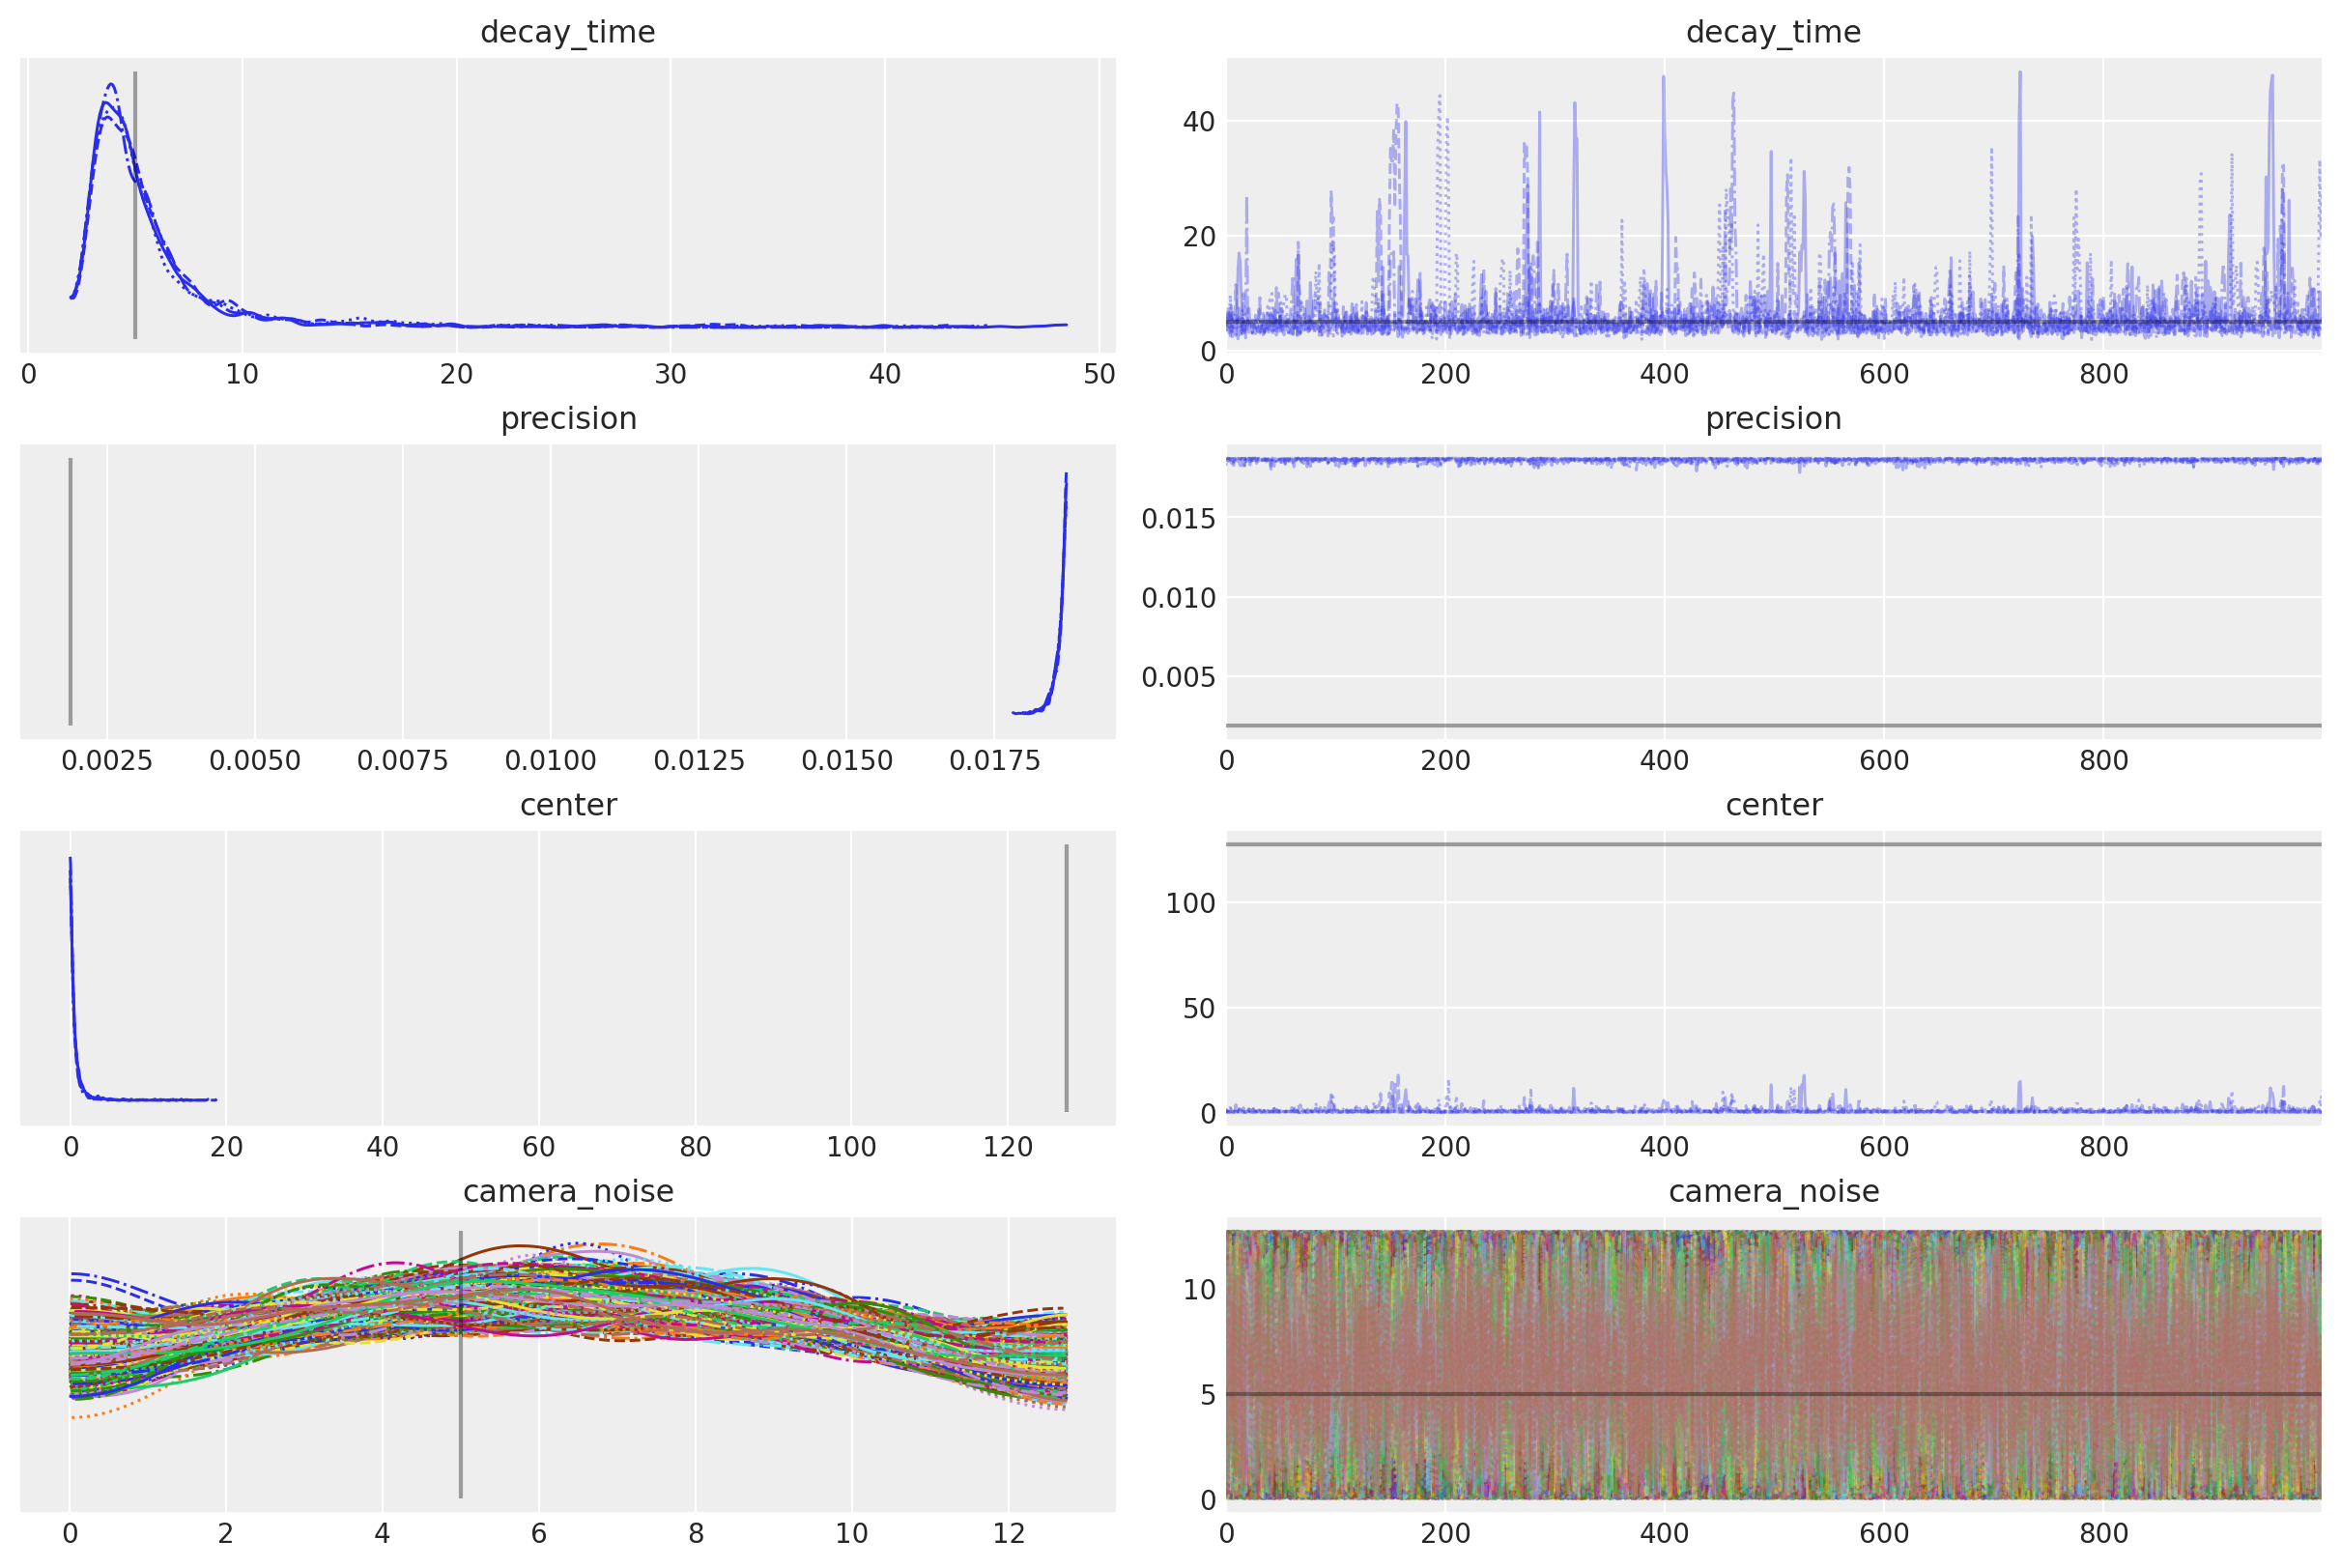

In [56]:
az.plot_trace(
    idata,
    lines=[
        ("decay_time", {}, tao_mean),
        ("precision", {}, 1/(innovation_std**2/(intensity_mean/(quantization*image_brightness))**2)),
        ("center", {}, quantization*image_brightness),
        ("camera_noise",{},camera_noise_mean)
    ],
);